In [1]:
%matplotlib inline

import pathlib
import subprocess

import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pm_remez
import scipy.signal
import spiceypy as sp

plt.rcParams['figure.figsize'] = (7, 3.5)

# Doppler calculation with SPICE

In [2]:
f_tx = 1299.5e6  # transmit frequency in Hz

In [3]:
kernels = pathlib.Path('spice').glob('*')
for kernel in kernels:
    sp.furnsh(str(kernel))

In [4]:
def radar_dlt(target, t_rx, transmitter, receiver=None):
    if receiver is None:
        receiver = transmitter
    ez_r, lt_r = sp.spkezr(target, t_rx, 'J2000', 'CN', receiver)
    ez_d, lt_d = sp.spkezr(transmitter, t_rx - lt_r, 'J2000', 'CN', target)
    dlt_r = sp.dvnorm(ez_r) / sp.clight()
    ez_d[3:] *= 1 - dlt_r
    dlt_d = sp.dvnorm(ez_d) / sp.clight()
    return dlt_r + dlt_d

def radar_surface_dlt(target, surf_vec, surf_frame, t_rx, transmitter, receiver=None):
    if receiver is None:
        receiver = transmitter
    target_radius = sp.bodvrd(target, 'RADII', 3)[1][0]
    surf_vec = np.array(surf_vec)
    surf_vec = target_radius * sp.unorm(surf_vec)[0]
    ez_r, lt_r = sp.spkcpt(surf_vec, target, surf_frame, t_rx, 'J2000', 'OBSERVER', 'CN', receiver)
    ez_d, lt_d = sp.spkcpo(transmitter, t_rx - lt_r, 'J2000', 'OBSERVER', 'CN', surf_vec, target, surf_frame)
    dlt_r = sp.dvnorm(ez_r) / sp.clight()
    ez_d[3:] *= 1 - dlt_r
    dlt_d = sp.dvnorm(ez_d) / sp.clight()
    return dlt_r + dlt_d

def radar_srp_dlt(target, target_frame, t_rx, transmitter, receiver=None):
    if receiver is None:
        receiver = transmitter
    srp, t_ref, _ = sp.subpnt('INTERCEPT/ELLIPSOID', target, t_rx, target_frame, 'CN', receiver)
    ez_r, lt_r = sp.spkcpt(srp, target, target_frame, t_rx, 'J2000', 'OBSERVER', 'CN', receiver)
    assert np.abs(t_rx - t_ref - lt_r) < 1e-6
    ez_d, lt_d = sp.spkcpo(transmitter, t_rx - lt_r, 'J2000', 'OBSERVER', 'CN', srp, target, target_frame)
    dlt_r = sp.dvnorm(ez_r) / sp.clight()
    ez_d[3:] *= 1 - dlt_r
    dlt_d = sp.dvnorm(ez_d) / sp.clight()
    return dlt_r + dlt_d

In [5]:
csv = {}
observatories = ['DWINGELOO', 'STOCKERT']

with open('dwingeloo_venus_doppler.csv') as f:
    csv['DWINGELOO'] = f.readlines()

with open('stockert_venus_doppler.csv') as f:
    csv['STOCKERT'] = f.readlines()

for obs in observatories:
    assert [a.split(',')[0] for a in csv['DWINGELOO'][1:]] == [a.split(',')[0] for a in csv[obs][1:]]

In [6]:
utcs = [a.split(',')[0] for a in csv['DWINGELOO'][1:]]
utcs_dt64 = np.array([np.datetime64(utc) for utc in utcs])
dopplers_csv = {k: np.array([float(a.split(',')[1]) for a in v[1:]])
                for k, v in csv.items()}

In [7]:
# Create kernels for Venus surface
NSIDE = 60
healpix_resol_deg = hp.nside2resol(NSIDE, arcmin=True) / 60
NPIX = hp.nside2npix(NSIDE)
print(f'HEALPix approx. resolution = {healpix_resol_deg:.2f} deg, NPIX = {NPIX}')

HEALPix approx. resolution = 0.98 deg, NPIX = 43200


In [8]:
dlts = {
    obs: np.array([radar_dlt('VENUS', sp.str2et(utc), transmitter='DWINGELOO', receiver=obs) for utc in utcs])
    for obs in observatories
}

dlts_srp = {
    obs: np.array([radar_srp_dlt('VENUS', 'IAU_VENUS', sp.str2et(utc), transmitter='DWINGELOO', receiver=obs) for utc in utcs])
    for obs in observatories
}

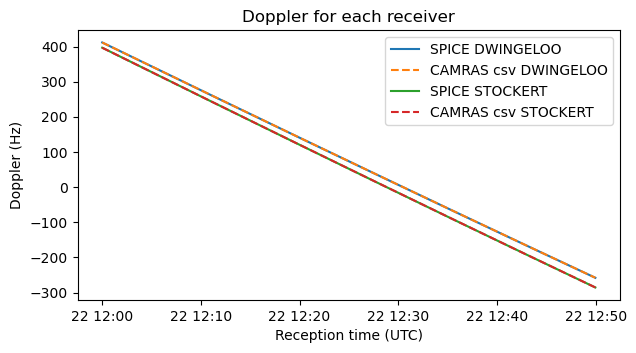

In [9]:
for obs in observatories:
    plt.plot(utcs_dt64, -dlts[obs] * f_tx, label=f'SPICE {obs}')
    plt.plot(utcs_dt64, dopplers_csv[obs], '--', label=f'CAMRAS csv {obs}')
plt.legend()
plt.title('Doppler for each receiver')
plt.xlabel('Reception time (UTC)')
plt.ylabel('Doppler (Hz)');

In [10]:
relative_time = (utcs_dt64 - utcs_dt64[0]) / np.timedelta64(1, 's')
for obs in observatories:
    with open(f'doppler_{obs.lower()}.txt', 'w') as f:
        for j in range(relative_time.size):
            print(f'{relative_time[j]} {-dlts[obs][j] * f_tx}', file=f)

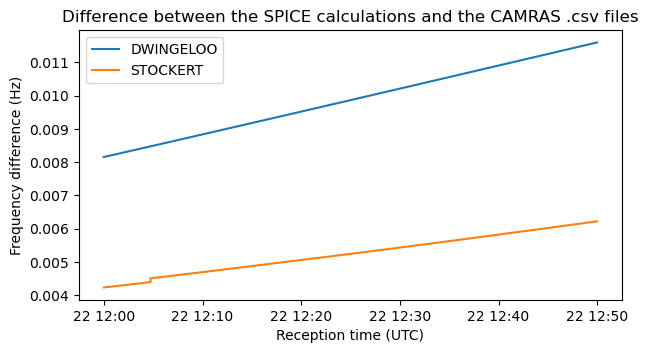

In [11]:
for obs in observatories:
    plt.plot(utcs_dt64, -dlts[obs] * f_tx - dopplers_csv[obs], label=obs)
plt.legend()
plt.title('Difference between the SPICE calculations and the CAMRAS .csv files')
plt.xlabel('Reception time (UTC)')
plt.ylabel('Frequency difference (Hz)');

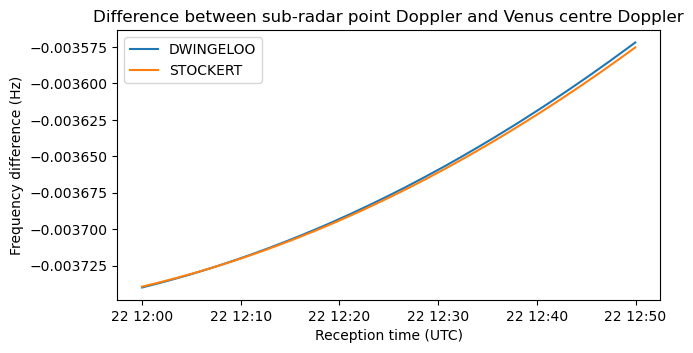

In [12]:
for obs in observatories:
    plt.plot(utcs_dt64, -dlts_srp[obs] * f_tx - (-dlts[obs] * f_tx), label=obs)
plt.legend()
plt.title('Difference between sub-radar point Doppler and Venus centre Doppler')
plt.xlabel('Reception time (UTC)')
plt.ylabel('Frequency difference (Hz)');

In [13]:
utc_subsample = np.arange(0, len(utcs), 600)
dlt_surface = np.array(
    [[radar_surface_dlt('VENUS', hp.pix2vec(NSIDE, n), 'IAU_VENUS', sp.str2et(utcs[k]), transmitter='DWINGELOO', receiver='DWINGELOO')
      for k in utc_subsample]
     for n in range(NPIX)]
)

In [14]:
def offnormal_angle(target, surf_vec, surf_frame, t_rx, transmitter, receiver):
    target_radius = sp.bodvrd(target, 'RADII', 3)[1][0]
    surf_vec = np.array(surf_vec)
    surf_vec = target_radius * sp.unorm(surf_vec)[0]
    _, lt_r = sp.spkcpt(surf_vec, target, surf_frame, t_rx, 'J2000', 'OBSERVER', 'CN', receiver)
    pos_r, lt_r = sp.spkcpo(receiver, t_rx - lt_r, 'J2000', 'OBSERVER', 'XCN+S', surf_vec, target, surf_frame)
    pos_r = pos_r[:3]
    pos_d, _ = sp.spkcpo(transmitter, t_rx - lt_r, 'J2000', 'OBSERVER', 'CN+S', surf_vec, target, surf_frame)
    pos_d = pos_d[:3]
    surf_norm = sp.unorm(sp.mxv(sp.pxform(surf_frame, 'J2000', t_rx - lt_r), surf_vec))[0]
    scattering = sp.unorm(sp.unorm(pos_r)[0] + sp.unorm(pos_d)[0])[0]
    return np.rad2deg(np.acos(np.dot(scattering, surf_norm)))

In [15]:
angles_surface = np.array(
    [[offnormal_angle('VENUS', hp.pix2vec(NSIDE, n), 'IAU_VENUS', sp.str2et(utcs[k]), transmitter='DWINGELOO', receiver='DWINGELOO')
      for k in utc_subsample]
     for n in range(NPIX)]
)

In [16]:
srp, _ = sp.spkpos('DWINGELOO', sp.str2et(utcs[0]), 'IAU_VENUS', 'CN+S', 'VENUS')
srp = np.rad2deg(sp.reclat(srp)[1:])
srp

array([-13.81708771,  -9.53936381])

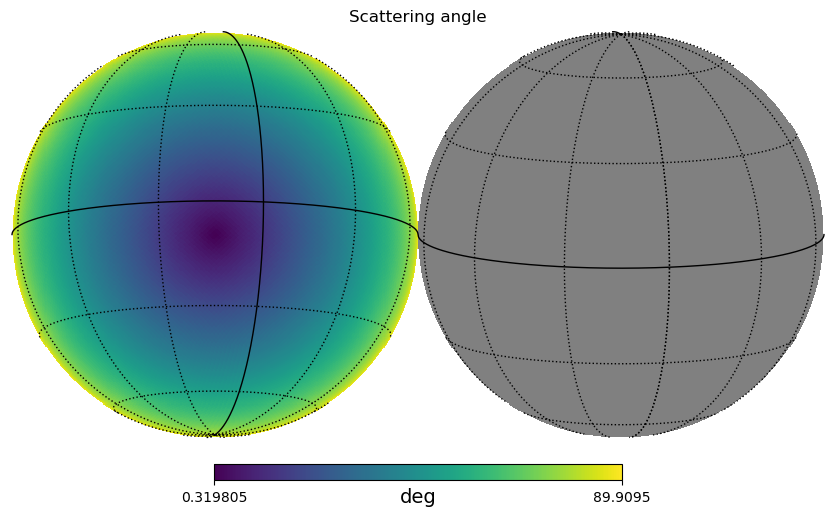

In [17]:
angles_surface_filt = np.copy(angles_surface)
angles_surface_filt[angles_surface > 90] = np.nan
hp.orthview(angles_surface_filt[:, 0], flip='geo', rot=srp, title='Scattering angle', unit='deg')
hp.graticule()

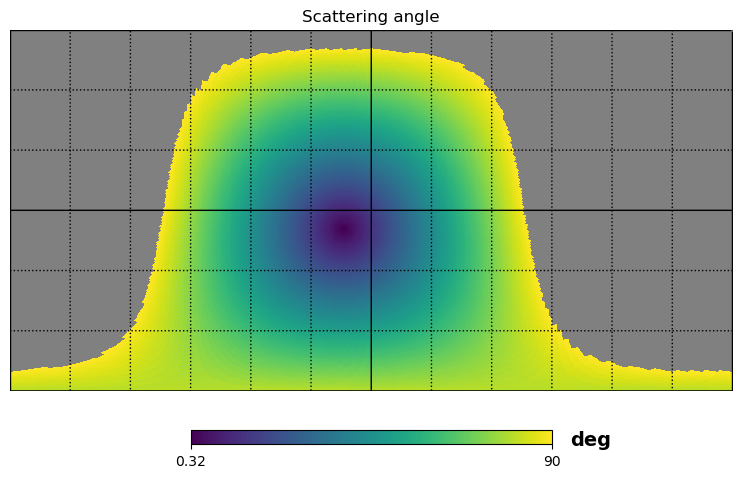

In [18]:
hp.cartview(angles_surface_filt[:, 0], flip='geo', title='Scattering angle', unit='deg')
hp.graticule()

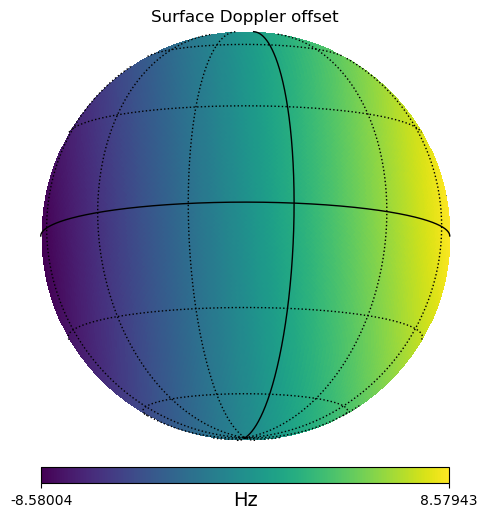

In [19]:
dlt_surface_filt = np.copy(dlt_surface)
dlt_surface_filt[angles_surface > 90] = np.nan

doppler_surface_offset = -(dlt_surface_filt - dlts['DWINGELOO'][utc_subsample]) * f_tx

hp.orthview(doppler_surface_offset[:, 0], flip='geo', rot=srp, half_sky=True,
            title='Surface Doppler offset', unit='Hz')
hp.graticule()

In [20]:
doppler_offset_max = np.nanmax(doppler_surface_offset, axis=0)
doppler_offset_min = np.nanmin(doppler_surface_offset, axis=0)

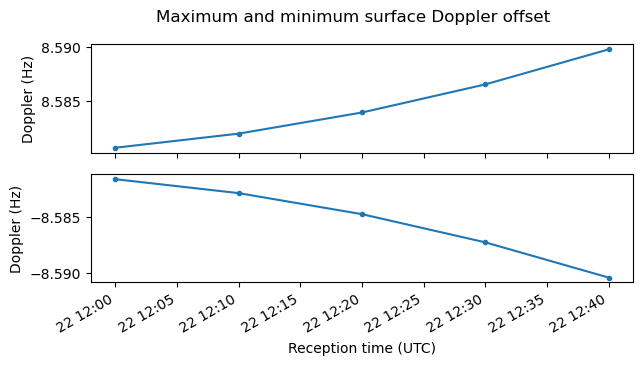

In [21]:
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(utcs_dt64[utc_subsample], doppler_offset_max, '.-',)
axs[1].plot(utcs_dt64[utc_subsample], doppler_offset_min, '.-',)
plt.gcf().autofmt_xdate()
plt.suptitle('Maximum and minimum surface Doppler offset')
axs[1].set_xlabel('Reception time (UTC)')
for ax in axs:
    ax.set_ylabel('Doppler (Hz)')

In [22]:
# Venus equatorial rotational velocity 1.81 m/s
2 * 1.81e-3 / sp.clight() * f_tx

15.69148880990195

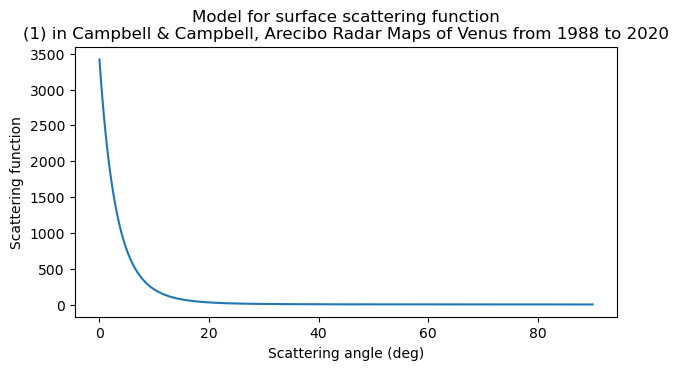

In [23]:
angles_x = np.linspace(0, 90, 1000)
plt.plot(angles_x, 10**(0.1*(35.34 - 1.41 * angles_x + 0.021 * angles_x**2 - 0.00011 * angles_x**3)))
plt.title('Model for surface scattering function\n(1) in Campbell & Campbell, Arecibo Radar Maps of Venus from 1988 to 2020')
plt.xlabel('Scattering angle (deg)')
plt.ylabel('Scattering function');

In [24]:
offsets = doppler_surface_offset[:, 0]
offsets_mass = 10**(0.1*(35.34 - 1.41 * angles_surface[:, 0] + 0.021 * angles_surface[:, 0]**2 - 0.00011 * angles_surface[:, 0]**3))
sel = ~np.isnan(offsets)
offsets = offsets[sel]
offsets_mass = offsets_mass[sel]
doppler_spread_xaxis = np.linspace(doppler_offset_min[0], doppler_offset_max[0], 1000)

In [25]:
doppler_spread_sigma = 0.1
doppler_spread_yaxis = np.sum(offsets_mass * np.exp(-0.5*(doppler_spread_xaxis[:, np.newaxis] - offsets)**2/doppler_spread_sigma**2),
                              axis=1)
doppler_spread_yaxis /= np.max(doppler_spread_yaxis)

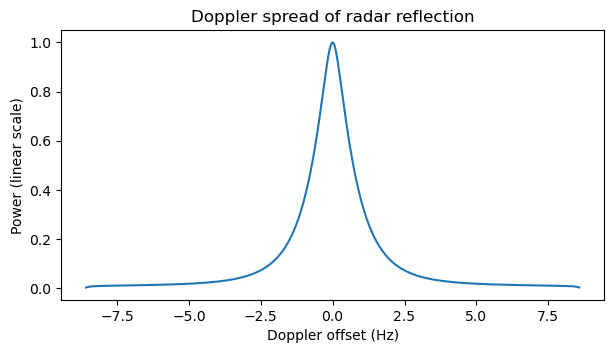

In [26]:
plt.plot(doppler_spread_xaxis, doppler_spread_yaxis)
plt.title('Doppler spread of radar reflection')
plt.xlabel('Doppler offset (Hz)')
plt.ylabel('Power (linear scale)');

# Calculation of IQ file segments containing received pulses

In [27]:
pulse_tx_times = [
    '2025-03-22T12:01:00', '2025-03-22T12:05:38',
    '2025-03-22T12:11:00', '2025-03-22T12:15:38',
    '2025-03-22T12:21:00', '2025-03-22T12:25:38',
    '2025-03-22T12:31:00', '2025-03-22T12:35:38',
]

def tx_delay(target, t_tx, transmitter, receiver):
    _, lt_d = sp.spkpos(target, t_tx, 'J2000', 'XCN', transmitter)
    _, lt_r = sp.spkezr(receiver, t_tx + lt_d, 'J2000', 'XCN', target)
    return lt_d + lt_r

pulse_rx_times = {
    obs: np.array([np.datetime64(p) + np.timedelta64(1, 'ns') * (1e9 * tx_delay('VENUS', sp.str2et(p), 'DWINGELOO', obs))
                   for p in pulse_tx_times])
    for obs in observatories
}

pulse_rx_times

{'DWINGELOO': array(['2025-03-22T12:05:40.015406203', '2025-03-22T12:10:18.015341344',
        '2025-03-22T12:15:40.015283006', '2025-03-22T12:20:18.015247089',
        '2025-03-22T12:25:40.015222167', '2025-03-22T12:30:18.015214999',
        '2025-03-22T12:35:40.015223246', '2025-03-22T12:40:18.015244591'],
       dtype='datetime64[ns]'),
 'STOCKERT': array(['2025-03-22T12:05:40.014859275', '2025-03-22T12:10:18.014798044',
        '2025-03-22T12:15:40.014744229', '2025-03-22T12:20:18.014712492',
        '2025-03-22T12:25:40.014692728', '2025-03-22T12:30:18.014690285',
        '2025-03-22T12:35:40.014704315', '2025-03-22T12:40:18.014730921'],
       dtype='datetime64[ns]')}

In [28]:
padding = 2 * sp.bodvrd('VENUS', 'RADII', 3)[1][0] / sp.clight()
padding = -(-1)**np.arange(len(pulse_tx_times)) * padding
samp_rate = 5000
pulse_sample_slices = {
    obs: np.int64(np.round(
        samp_rate * ((pulse_rx_times[obs] - np.datetime64('2025-03-22T12:00:00')) / np.timedelta64(1, 's') + padding)))
    for obs in observatories
}
pulse_sample_slices

{'DWINGELOO': array([ 1699875,  3090279,  4699875,  6090278,  7699874,  9090278,
        10699874, 12090278]),
 'STOCKERT': array([ 1699872,  3090276,  4699872,  6090275,  7699872,  9090275,
        10699872, 12090276])}

# Design of high-quality PFB spectrum analyzer

In [29]:
# copied from https://pm-remez.readthedocs.io/en/latest/
# added cutoff_shift parameter
def design_antialias_lowpass(decimation, transition_bandwidth, numtaps,
                             stopband_weight=1.0, one_over_f=False,
                             bigfloat=False, worN=4096, cutoff_shift=0.0):
    passband_end = 0.5 * (1 + cutoff_shift - transition_bandwidth) / decimation
    stopband_start = 0.5 * (1 + cutoff_shift + transition_bandwidth) / decimation
    # Stopband weight is a constant or linear slope depending
    # on one_over_f parameter.
    sweight = ((stopband_weight, stopband_weight * 0.5 / stopband_start)
               if one_over_f else stopband_weight)
    design = pm_remez.remez(
                 numtaps, [0, passband_end, stopband_start, 0.5],
                 [1, 0], weight=[1, sweight], bigfloat=bigfloat)

    # Compute and plot the frequency response of the filter
    w, h = scipy.signal.freqz(design.impulse_response, [1], worN=worN, fs=1)
    fig, axs = plt.subplots(2, 1, figsize=(7, 6))
    for j, ax in enumerate(axs):
        ax.plot(w, 20 * np.log10(np.abs(h)))
        att_db = 20 * np.log10(design.weighted_error / stopband_weight)
        ripple_db = 20 * np.log10(1 + design.weighted_error)
        for sign in [-1, 1]:
            ax.axvline(x=0.5 * (1 + sign * transition_bandwidth) / decimation,
                       color='grey', linestyle=':')
        ax.axhline(y=att_db, color='grey', linestyle=':')
        for f in design.extremal_freqs:
            hf = 20 * np.log10(np.abs(np.sum(
                     np.array(design.impulse_response)
                     * np.exp(1j * 2 * np.pi * f
                     * np.arange(len(design.impulse_response))))))
            ax.plot(f, hf, '.', color='red')
        if j == 0:
            max_att = att_db
            if one_over_f:
                max_att -= 20 * np.log10(0.5 / stopband_start)
            ax.set_ylim((max_att - 10, 3))
        else:
            ax.set_ylim((-2 * ripple_db, 2 * ripple_db))
            ax.set_xlim((-0.02 / decimation, 0.5 / decimation))
            ax.axhline(y=ripple_db, color='grey', linestyle=':')
            ax.axhline(y=20 * np.log10(1 - design.weighted_error),
                       color='grey', linestyle=':')
        ax.grid()
        ax.set_xlabel('Normalized frequency')
        ax.set_ylabel('Gain (dB)')
    plt.subplots_adjust(hspace=0.3)

    return design

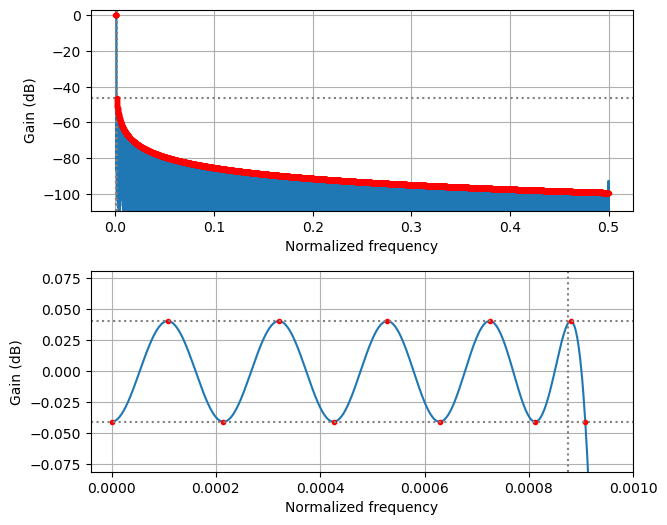

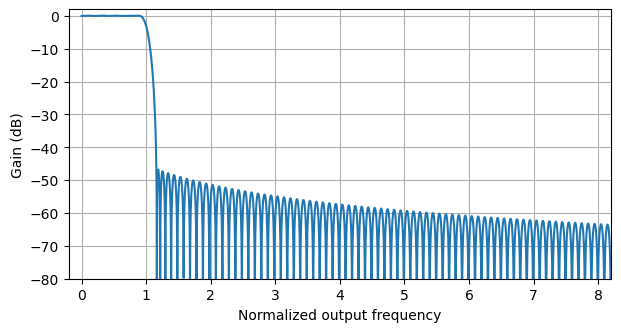

In [30]:
num_channels = 1000
taps_per_channel = 10
oversampling_freq = 2
pfb_design = design_antialias_lowpass(num_channels // oversampling_freq, 0.125, num_channels * taps_per_channel,
                                      stopband_weight=1, one_over_f=True, worN=2**18,
                                      cutoff_shift=0.033)

w, h = scipy.signal.freqz(pfb_design.impulse_response, [1], worN=2**18, fs=1)
plt.figure()
plt.plot(w * num_channels, 20*np.log10(np.abs(h)))
plt.xlim((-0.2, 8 + 0.2))
plt.ylim((-80, 2))
plt.grid()
plt.xlabel('Normalized output frequency')
plt.ylabel('Gain (dB)')
plt.show()

/tmp/ipykernel_56277/356695940.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w * NFFT, 20*np.log10(np.abs(h)))
/tmp/ipykernel_56277/356695940.py:18: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w * NFFT, 20*np.log10(np.abs(h)))
/tmp/ipykernel_56277/356695940.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w * NFFT, 20*np.log10(np.abs(h)), label='Bin 0')
/tmp/ipykernel_56277/356695940.py:47: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w * NFFT, 20*np.log10(np.abs(h)), label='Bin 0')


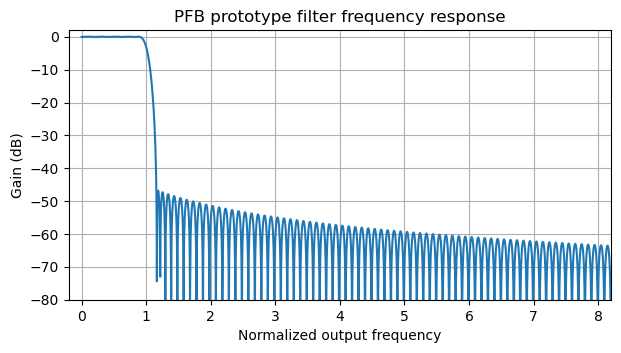

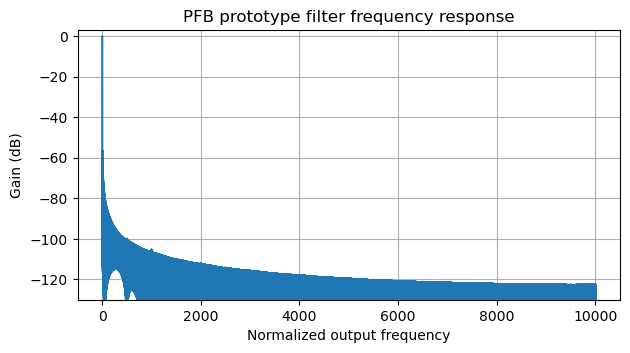

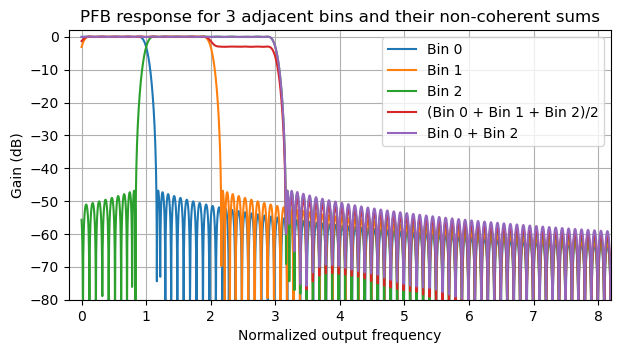

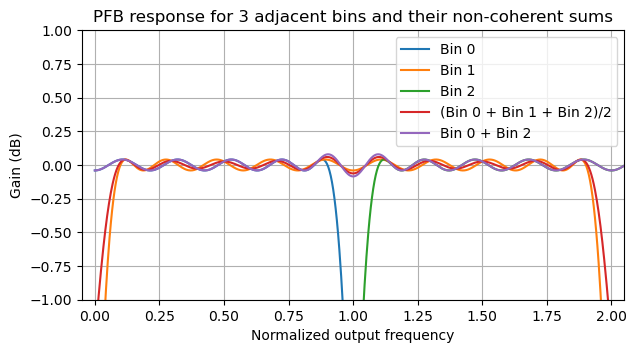

In [31]:
NFFT = 4 * samp_rate  # bin spacing 0.25 Hz, bin width 0.5 Hz
interp_factor = NFFT // num_channels
interp_taps = np.interp(np.arange(NFFT * taps_per_channel),
                        np.arange(0, NFFT * taps_per_channel, interp_factor),
                        pfb_design.impulse_response) / interp_factor
pfb_taps = interp_taps.reshape(-1, NFFT)

w, h = scipy.signal.freqz(interp_taps, [1], worN=2**22, fs=1)
plt.plot(w * NFFT, 20*np.log10(np.abs(h)))
plt.xlim((-0.2, 8 + 0.2))
plt.ylim((-80, 2))
plt.grid()
plt.xlabel('Normalized output frequency')
plt.ylabel('Gain (dB)')
plt.title('PFB prototype filter frequency response')

plt.figure()
plt.plot(w * NFFT, 20*np.log10(np.abs(h)))
plt.ylim(-130, 3)
plt.grid()
plt.xlabel('Normalized output frequency')
plt.ylabel('Gain (dB)')
plt.title('PFB prototype filter frequency response')


_, h2 = scipy.signal.freqz(interp_taps * np.exp(1j*2*np.pi/NFFT*np.arange(interp_taps.size)),
                           [1], worN=2**22, fs=1)
_, h3 = scipy.signal.freqz(interp_taps * np.exp(1j*2*np.pi*2/NFFT*np.arange(interp_taps.size)),
                           [1], worN=2**22, fs=1)
plt.figure()
plt.plot(w * NFFT, 20*np.log10(np.abs(h)), label='Bin 0')
plt.plot(w * NFFT, 20*np.log10(np.abs(h2)), label='Bin 1')
plt.plot(w * NFFT, 20*np.log10(np.abs(h3)), label='Bin 2')
plt.plot(w * NFFT, 10*np.log10(0.5*(np.abs(h)**2 + np.abs(h2)**2 + np.abs(h3)**2)),
         label='(Bin 0 + Bin 1 + Bin 2)/2')
plt.plot(w * NFFT, 10*np.log10(np.abs(h)**2 + np.abs(h3)**2),
         label='Bin 0 + Bin 2')
plt.legend()
plt.xlim((-0.2, 8 + 0.2))
plt.ylim((-80, 2))
plt.grid()
plt.xlabel('Normalized output frequency')
plt.ylabel('Gain (dB)')
plt.title('PFB response for 3 adjacent bins and their non-coherent sums')

plt.figure()
plt.plot(w * NFFT, 20*np.log10(np.abs(h)), label='Bin 0')
plt.plot(w * NFFT, 20*np.log10(np.abs(h2)), label='Bin 1')
plt.plot(w * NFFT, 20*np.log10(np.abs(h3)), label='Bin 2')
plt.plot(w * NFFT, 10*np.log10(0.5*(np.abs(h)**2 + np.abs(h2)**2 + np.abs(h3)**2)),
         label='(Bin 0 + Bin 1 + Bin 2)/2')
plt.plot(w * NFFT, 10*np.log10(np.abs(h)**2 + np.abs(h3)**2),
         label='Bin 0 + Bin 2')
plt.legend()
plt.xlim((-0.05, 2 + 0.05))
plt.ylim((-1, 1))
plt.grid()
plt.xlabel('Normalized output frequency')
plt.ylabel('Gain (dB)')
plt.title('PFB response for 3 adjacent bins and their non-coherent sums');

# Frequency analysis of Doppler-corrected IQ data

In [32]:
samples = [
    ('STOCKERT', np.fromfile('stockert_chan0_doppler_corrected_5ksps.c64', 'complex64')),
    ('STOCKERT', np.fromfile('stockert_chan1_doppler_corrected_5ksps.c64', 'complex64')),
    ('DWINGELOO', np.fromfile('dwingeloo_doppler_corrected_5ksps.c64', 'complex64')),
]

pulse_samples = [
    [
        s[1][pulse_sample_slices[s[0]][n]:pulse_sample_slices[s[0]][n + 1]+1]
        for n in range(0, len(pulse_tx_times), 2)
    ]
    for s in samples
]

del samples

L = np.max([s.size for pulses in pulse_samples for s in pulses])

oversampling_time = 2
fft_oversampling = oversampling_freq * oversampling_time

samples_pad = np.zeros((
    len(pulse_samples),
    len(pulse_tx_times) // 2,
    ((L + NFFT - 1) // NFFT + 2 * taps_per_channel - 1) * NFFT - NFFT // fft_oversampling),
    'complex')

for j in range(len(pulse_samples)):
    for k in range(len(pulse_tx_times) // 2):
        y = pulse_samples[j][k]
        samples_pad[j, k, (taps_per_channel - 1) * NFFT:][:y.size] = y

del pulse_samples

pfb_filt = np.zeros((samples_pad.shape[0], samples_pad.shape[1],
                     ((L + NFFT - 1) // NFFT + taps_per_channel - 1) * fft_oversampling,
                     NFFT), 'complex')
for j in range(pfb_filt.shape[2]):
    for k in range(taps_per_channel):
        pfb_filt[:, :, j] += samples_pad[:, :, j * NFFT // fft_oversampling + k * NFFT:][:, :, :NFFT] * pfb_taps[k]

del samples_pad

pfb_filt = np.fft.fftshift(np.fft.fft(pfb_filt), axes=-1)

pfb_xcorr = pfb_filt[:, np.newaxis, ...] * np.conjugate(pfb_filt[np.newaxis, ...])

del pfb_filt

freq_axis = np.fft.fftshift(np.fft.fftfreq(NFFT, 1/samp_rate))

noise_measure_sel = np.concatenate((np.arange(NFFT//4, NFFT//2-NFFT//200),
                                    np.arange(NFFT//2+NFFT//200, NFFT - NFFT//4)))

/usr/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


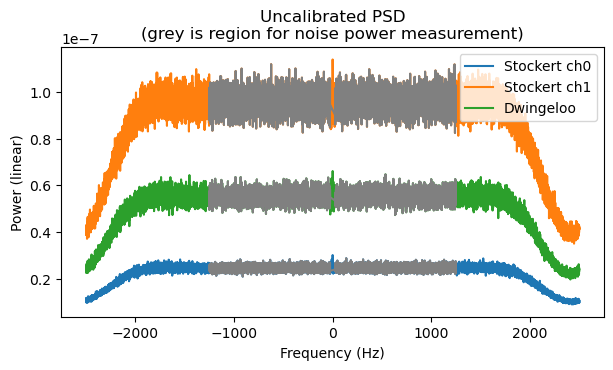

In [33]:
channels = ['Stockert ch0', 'Stockert ch1', 'Dwingeloo']

for j in range(pfb_xcorr.shape[0]):
    plt.plot(freq_axis, np.sum(pfb_xcorr[j, j], axis=(0, 1)), label=channels[j])
    plt.plot(freq_axis[noise_measure_sel], np.sum(pfb_xcorr[j, j][..., noise_measure_sel], axis=(0, 1)), color='grey')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (linear)')
plt.title('Uncalibrated PSD\n(grey is region for noise power measurement)');

In [34]:
noise = np.sum(np.average(np.einsum('ii...->i...', pfb_xcorr[..., noise_measure_sel]), axis=-1), axis=(1, 2))

pfb_xcorr_cal = pfb_xcorr / (np.sqrt(noise)[:, np.newaxis] * np.sqrt(noise))[..., np.newaxis, np.newaxis, np.newaxis]

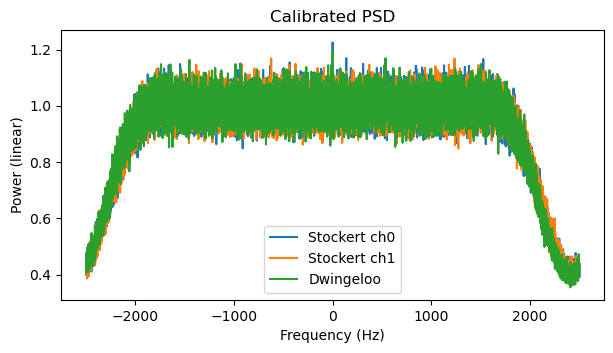

In [35]:
for j in range(3):
    plt.plot(freq_axis, np.sum(pfb_xcorr_cal[j, j], axis=(0, 1)), label=channels[j])
    plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (linear)')
plt.title('Calibrated PSD');

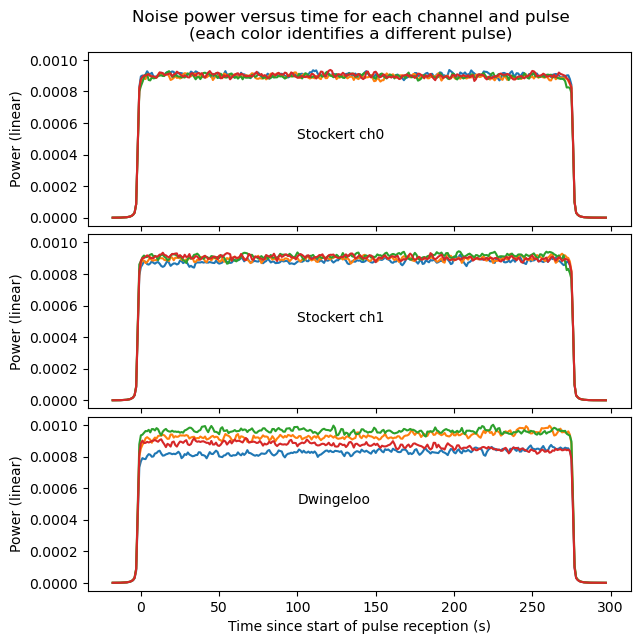

In [36]:
noise_vs_time = np.average(np.einsum('ii...->i...', pfb_xcorr_cal)[..., noise_measure_sel], axis=-1)
fig, axs = plt.subplots(noise_vs_time.shape[0], 1, sharex=True, sharey=True, figsize=(7, 7))
taxis = (np.arange(noise_vs_time.shape[2]) - (taps_per_channel - 1)*fft_oversampling/2) * NFFT / (samp_rate * fft_oversampling)
for j, n in enumerate(noise_vs_time):
    axs[j].plot(taxis, n.T)
    axs[j].set_ylabel('Power (linear)')
plt.subplots_adjust(hspace=0.05)
axs[0].text(100, 5e-4, 'Stockert ch0')
axs[1].text(100, 5e-4, 'Stockert ch1')
axs[2].text(100, 5e-4, 'Dwingeloo')
axs[-1].set_xlabel('Time since start of pulse reception (s)')
plt.suptitle('Noise power versus time for each channel and pulse\n(each color identifies a different pulse)', y=0.94);

In [37]:
pfb_xcorr_cal_notime = np.sum(pfb_xcorr_cal, axis=(2, 3))

In [38]:
def normalize_spectrum(spec):
    spec = spec - np.mean(spec[noise_measure_sel])
    spec /= np.sqrt(np.mean(spec[noise_measure_sel]**2))
    return spec

In [39]:
sel = np.abs(freq_axis) <= 10
signal_bins = np.abs(freq_axis) <= 0.5
window = 5

def smooth(x):
    return np.convolve(np.ones(window)/window, x, mode='same')

In [40]:
np.rad2deg(np.angle(np.sum(pfb_xcorr_cal_notime[0, 1, signal_bins]))) % 360

np.float64(280.0654929111098)

In [41]:
stockert_phase_offset = 280
stockert_phase_offset_camras = 260

In [42]:
def coherent_combine(j, k, phase=np.deg2rad(stockert_phase_offset), x=pfb_xcorr_cal_notime):
    return 0.5 * (x[j, j] + x[k, k] + 2 * (x[j, k] * np.exp(-1j * phase)).real)

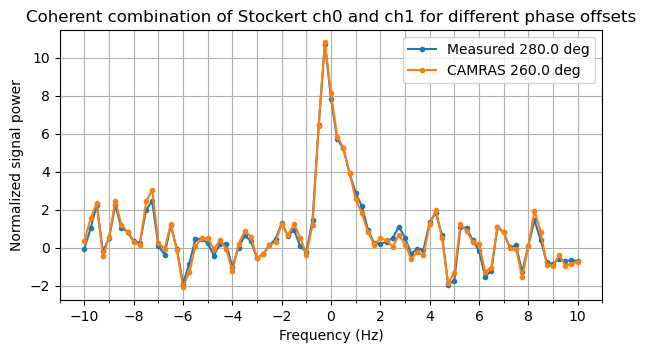

In [43]:
plt.plot(freq_axis[sel], normalize_spectrum(coherent_combine(0, 1))[sel],
         '.-', label=f'Measured {stockert_phase_offset:.1f} deg')
plt.plot(freq_axis[sel], normalize_spectrum(coherent_combine(0, 1, np.deg2rad(stockert_phase_offset_camras)))[sel],
         '.-', label=f'CAMRAS {stockert_phase_offset_camras:.1f} deg')
plt.legend()
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=2))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=1))
plt.grid(which='both')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized signal power')
plt.title('Coherent combination of Stockert ch0 and ch1 for different phase offsets');

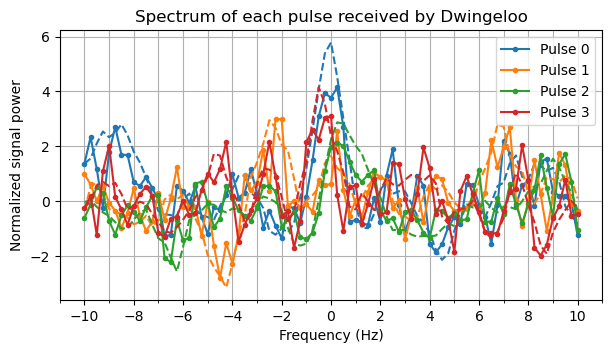

In [44]:
for j in range(4):
    plt.plot(freq_axis[sel], normalize_spectrum(np.sum(pfb_xcorr_cal[2, 2, j], axis=0))[sel], '.-', label=f'Pulse {j}')
    plt.plot(freq_axis[sel], normalize_spectrum(smooth(np.sum(pfb_xcorr_cal[2, 2, j], axis=0)))[sel],
             '--', color=f'C{j}')
plt.legend()
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=2))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=1))
plt.grid(which='both')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized signal power')
plt.title('Spectrum of each pulse received by Dwingeloo');

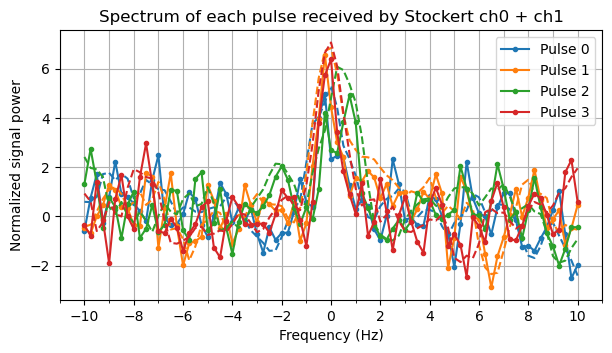

In [45]:
for j in range(4):
    plt.plot(freq_axis[sel], normalize_spectrum(np.sum(coherent_combine(0, 1, x=pfb_xcorr_cal)[j], axis=0))[sel], '.-',
             label=f'Pulse {j}')
    plt.plot(freq_axis[sel], normalize_spectrum(smooth(np.sum(coherent_combine(0, 1, x=pfb_xcorr_cal)[j], axis=0)))[sel],
             '--', color=f'C{j}')
plt.legend()
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=2))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=1))
plt.grid(which='both')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized signal power')
plt.title('Spectrum of each pulse received by Stockert ch0 + ch1');

In [46]:
stockert_cal = coherent_combine(0, 1, np.deg2rad(stockert_phase_offset))
dwingeloo_cal = pfb_xcorr_cal_notime[2, 2]

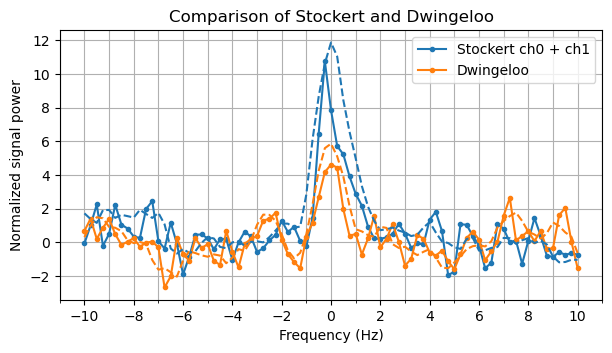

In [47]:
plt.plot(freq_axis[sel], normalize_spectrum(stockert_cal)[sel], '.-', label='Stockert ch0 + ch1')
plt.plot(freq_axis[sel], normalize_spectrum(dwingeloo_cal)[sel], '.-', label='Dwingeloo')
window = 5
plt.plot(freq_axis[sel], normalize_spectrum(smooth(stockert_cal))[sel], '--', color='C0')
plt.plot(freq_axis[sel], normalize_spectrum(smooth(dwingeloo_cal))[sel], '--', color='C1')
plt.legend()
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=2))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=1))
plt.grid(which='both')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized signal power')
plt.title('Comparison of Stockert and Dwingeloo');

In [48]:
stockert_pwr = np.sum(stockert_cal[signal_bins] - 1).real
dwingeloo_pwr = np.sum(dwingeloo_cal[signal_bins] - 1).real
stockert_pwr, dwingeloo_pwr

(np.float64(1.2971911240419982), np.float64(0.7547812992712857))

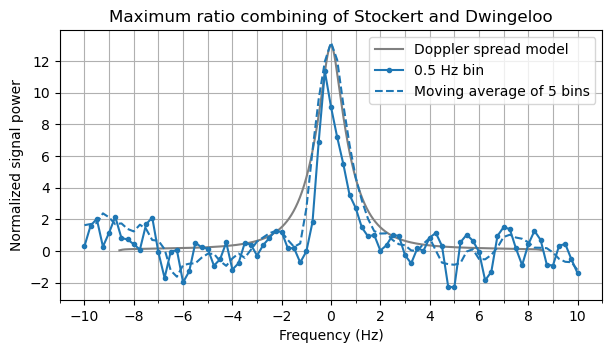

In [49]:
mrc = (stockert_pwr * stockert_cal + dwingeloo_pwr * dwingeloo_cal) / np.sqrt(stockert_pwr**2 + dwingeloo_pwr**2)
plt.plot(doppler_spread_xaxis, 13 * doppler_spread_yaxis, '-', color='grey', label='Doppler spread model')
plt.plot(freq_axis[sel], normalize_spectrum(mrc)[sel], '.-', label='0.5 Hz bin')
plt.plot(freq_axis[sel], normalize_spectrum(np.convolve(np.ones(window), mrc, mode='same'))[sel], '--', color='C0',
         label='Moving average of 5 bins')
plt.legend()
plt.gca().xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(base=2))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(base=1))
plt.grid(which='both')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Normalized signal power')
plt.title('Maximum ratio combining of Stockert and Dwingeloo');

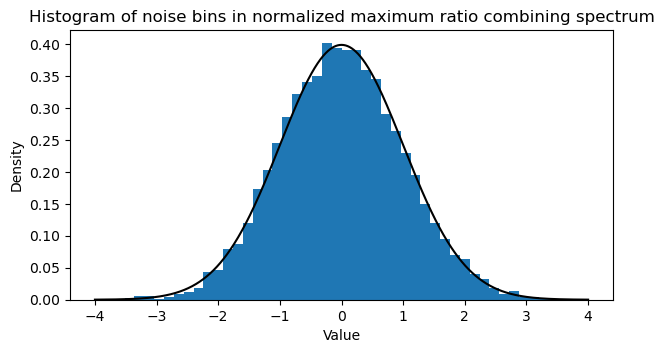

In [50]:
bins = np.linspace(-4, 4, 51)
pdf_x = np.linspace(-4, 4, 1000)
plt.hist(normalize_spectrum(mrc)[noise_measure_sel], bins, density=True)
plt.plot(pdf_x, np.exp(-0.5*pdf_x**2)/np.sqrt(2*np.pi), color='black')
plt.title('Histogram of noise bins in normalized maximum ratio combining spectrum')
plt.xlabel('Value')
plt.ylabel('Density');